In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library**

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, Conv1D

import random
import os

from tensorflow.random import set_seed
set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

# **Prepare Dataset**

In [ ]:
main_path = "/content/drive/MyDrive/Nexmedis/IMDB Dataset.csv"

df = pd.read_csv(main_path)

print(df.shape)
print(df.isnull().sum())  # check for missing data (NaN)
df.head()

(50000, 2)
review       0
sentiment    0
dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


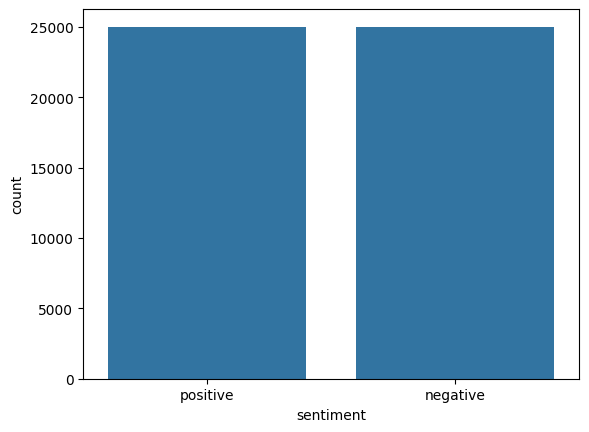

In [ ]:
# Visualizing data
sns.countplot(x='sentiment', data=df)
plt.show()

In [ ]:
# Data Preprocessing

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

custom_stopwords = stop_words - {'not', 'nor', 'no', 'never', 'none', 'nobody', 'nothing', 'neither',
                                 'very', 'too', 'just', 'only', 'almost', 'quite',
                                 'more', 'most', 'less', 'least',
                                 'without', 'against'}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)           # remove html tag
    text = re.sub(r'[^a-zA-Z]', ' ', text)         # remove punctuation
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)    # remove single alone word
    text = re.sub(r'\s+', ' ', text)               # remove more than 1 spacing

    words = word_tokenize(text)
    # words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words if word not in custom_stopwords]
    return ' '.join(words)

def preprocess_text2(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(words)

In [ ]:
df['clean_review'] = df['review'].apply(preprocess_text)
df['clean_review']

,clean_review
0,one reviewer mentioned watching just oz episod...
1,wonderful little production filming technique ...
2,thought wonderful way spend time too hot summe...
3,basically family little boy jake think zombie ...
4,petter mattei love time money visually stunnin...
...,...
49995,thought movie right good job creative original...
49996,bad plot bad dialogue bad acting idiotic direc...
49997,catholic taught parochial elementary school nu...
49998,going disagree previous comment side maltin on...


In [ ]:
x = df['clean_review'].tolist()
len(x)

y = df['sentiment'].tolist()
y = np.array(list(map(lambda x: 1 if x=='positive' else 0,y)))
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4)

print(len(xtrain), len(ytrain), len(xtest), len(ytest))

40000 40000 10000 10000


In [ ]:
token = Tokenizer()
token.fit_on_texts(xtrain)    # builds a vocabulary based on the unique words, calculate word freq

xtrain = token.texts_to_sequences(xtrain)
xtest = token.texts_to_sequences(xtest)

In [ ]:
# check the length of uniqe words base on built-in dict
vocab_length = len(token.word_index)+1
vocab_length

# len(xtrain)


81700

In [ ]:
# sequence_lengths = [len(seq) for seq in xtrain]   # total word for each data
# print(sequence_lengths)

# max_len = int(np.percentile(sequence_lengths, 95))
# print(max_len)

max_len = 100

xtrain = pad_sequences(xtrain, padding='post', maxlen=max_len)
xtest = pad_sequences(xtest, padding='post', maxlen=max_len)

# **Add Pre Trained Vector**

In [ ]:
embedding_dict = dict()

glove_file=open ('/content/drive/MyDrive/Nexmedis/glove.6B.100d.txt', encoding= 'utf8')
for line in glove_file:
  record = line.split()
  word = record[0]
  vector_dimension = np.asarray (record[1:], dtype='float32')
  embedding_dict[word] = vector_dimension
glove_file.close

# isi glove db :
# happy 0.1 0.3 -0.2 0.5
# pisahkan kata dan vektor lalu simpan ke embedding_dict

<function TextIOWrapper.close()>

In [ ]:
from numpy import zeros

embedding_matrix = zeros((vocab_length, 100))     # buat matriks kosong dg dimensi sebesar vocab
for word, index in token.word_index.items():      # for each word in my dict{index}
  embedding_vector = embedding_dict.get(word)     # vector utk embedding_dict["word"] diambil
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(81700, 100)

# **LSTM Model**

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
def get_lstm_model():
    inputs = layers.Input(shape=(max_len,))

    x = layers.Embedding(input_dim=vocab_length, output_dim=100,
                         weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

    x = layers.LSTM(128)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    return model

lstm_model = get_lstm_model()
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 100, 100)            │       8,170,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,287,377 (31.61 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 8,170,000 (31.17 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = "/content/drive/MyDrive/Nexmedis/Model Checkpoint/lstm-no-stopword.keras"

checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['acc'])

history = lstm_model.fit(xtrain, ytrain, batch_size=64, epochs=10,
                         verbose=1, validation_split=0.2, callbacks=[checkpoint])

score = lstm_model.evaluate(xtest, ytest)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - acc: 0.6987 - loss: 0.5662
Epoch 1: val_loss improved from inf to 0.41500, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/lstm-no-stopword.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 131ms/step - acc: 0.6988 - loss: 0.5661 - val_acc: 0.8185 - val_loss: 0.4150
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - acc: 0.8164 - loss: 0.4222
Epoch 2: val_loss improved from 0.41500 to 0.36005, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/lstm-no-stopword.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - acc: 0.8164 - loss: 0.4222 - val_acc: 0.8503 - val_loss: 0.3601
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - acc: 0.8438 - loss: 0.3637
Epoch 3: val_loss improved from 0.36005 to 0.35225, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/lstm-no-stopword.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - acc: 0.8438 - loss: 0.3637 - val_acc: 0.8497 - val_loss: 0.3523
Epoch

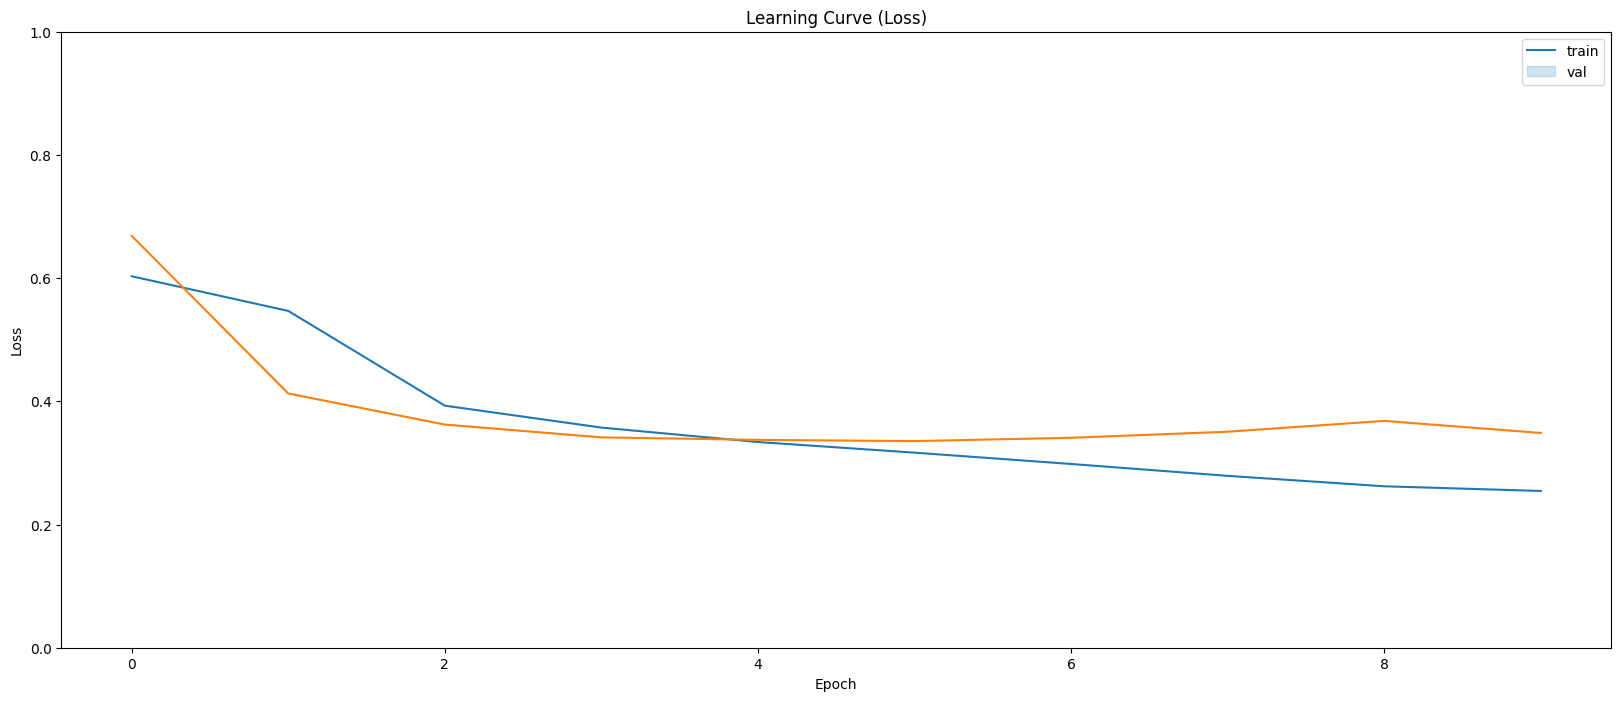

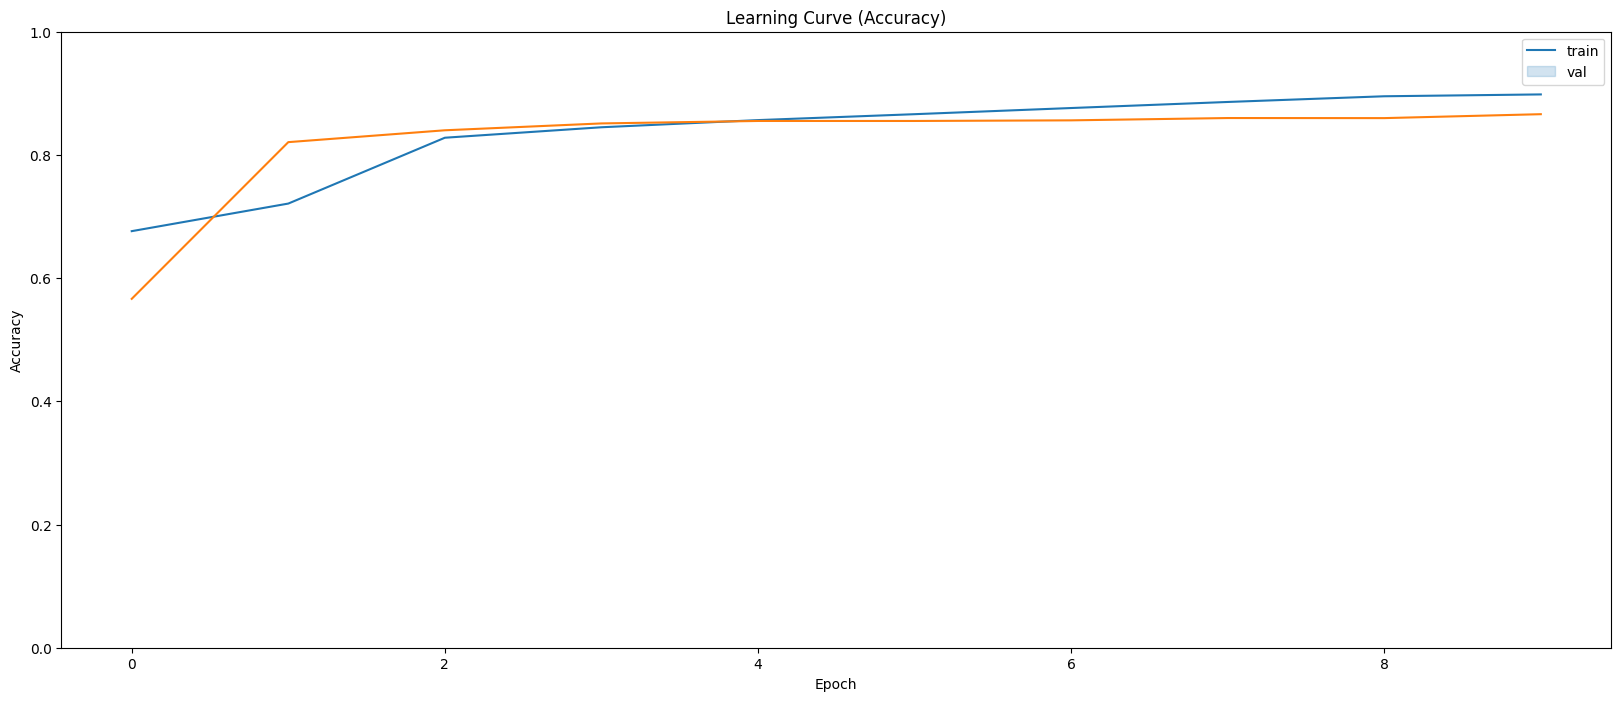

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['acc'])
sns.lineplot(x = history.epoch, y = history.history['val_acc'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

# **CNN Model**

In [ ]:
def get_cnn():
  inputs = layers.Input(shape=(max_len,))

  x = layers.Embedding(input_dim=vocab_length, output_dim=100,
                         weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

  x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
  x = layers.GlobalMaxPooling1D()(x)

  output = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=output)

  return model

cnn_model = get_cnn()
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_16 (Embedding)             │ (None, 100, 100)            │       8,169,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 100, 128)            │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,207,857 (31.31 MB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 8,169,200 (31.16 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = "/content/drive/MyDrive/Nexmedis/Model Checkpoint/cnn.keras"

checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [ ]:
cnn_model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics=['acc'])

history2 = cnn_model.fit(xtrain, ytrain, batch_size=32, epochs=10,
                         verbose=1, validation_split=0.2, callbacks=[checkpoint, plateau])

score2 = cnn_model.evaluate(xtest, ytest)
print(f"Test Loss: {score2[0]}")
print(f"Test Accuracy: {score2[1]}")

Epoch 1/10
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.6220 - loss: 0.6517
Epoch 1: val_loss improved from inf to 0.51153, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/cnn.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - acc: 0.6223 - loss: 0.6515 - val_acc: 0.7745 - val_loss: 0.5115 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7904 - loss: 0.4828
Epoch 2: val_loss improved from 0.51153 to 0.42366, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/cnn.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - acc: 0.7904 - loss: 0.4827 - val_acc: 0.8183 - val_loss: 0.4237 - learning_rate: 1.0000e-04
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8277 - loss: 0.4067
Epoch 3: val_loss improved from 0.42366 to 0.38804, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/cnn.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - acc: 0.8277 - loss: 0.4067 - val_acc: 0.8289 -

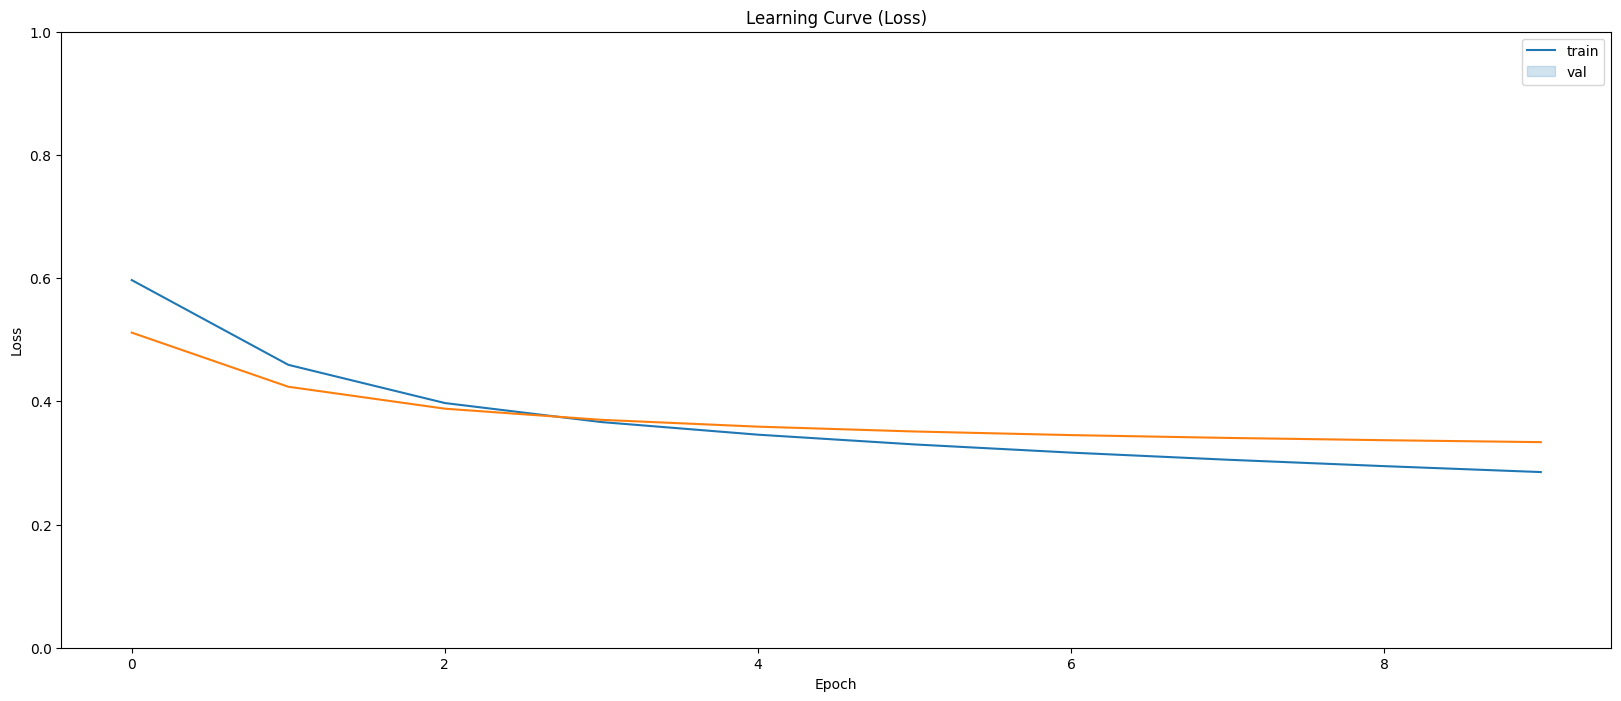

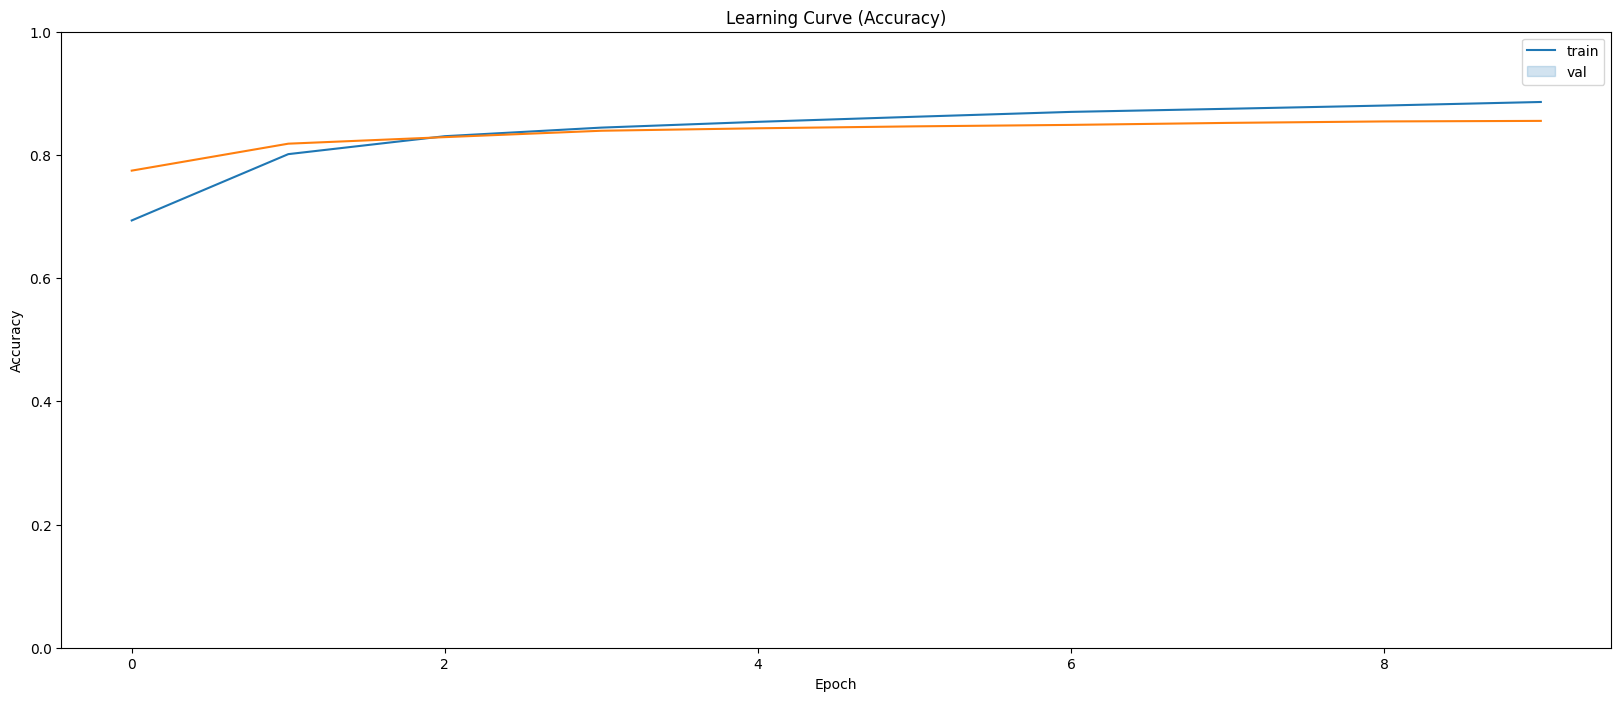

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['acc'])
sns.lineplot(x = history.epoch, y = history.history['val_acc'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

# **CNN-LSTM**

In [ ]:
def get_cnn_lstm():
  inputs = layers.Input(shape=(max_len,))

  x = layers.Embedding(input_dim=vocab_length, output_dim=100,
                         weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

  x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
  x = layers.MaxPooling1D(pool_size=2)(x)
  x = layers.LSTM(128)(x)

  x = layers.Dropout(0.5)(x)

  output = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=output)

  return model

cnn_lstm_model = get_cnn_lstm()
cnn_lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 100, 100)            │       8,169,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 100, 128)            │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,339,441 (31.81 MB)

 Trainable params: 170,241 (665.00 KB)

 Non-trainable params: 8,169,200 (31.16 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = "/content/drive/MyDrive/Nexmedis/Model Checkpoint/cnn-lstm-4.keras"

checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [ ]:
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.0009), metrics=['acc'])

history3 = cnn_lstm_model.fit(xtrain, ytrain, batch_size=64, epochs=20,
                         verbose=1, validation_split=0.2, callbacks=[checkpoint, plateau])

score3= cnn_lstm_model.evaluate(xtest, ytest)
print(f"Test Loss: {score3[0]}")
print(f"Test Accuracy: {score3[1]}")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9427 - loss: 0.1639
Epoch 1: val_loss improved from inf to 0.38509, saving model to /content/drive/MyDrive/Nexmedis/Model Checkpoint/cnn-lstm-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - acc: 0.9427 - loss: 0.1639 - val_acc: 0.8579 - val_loss: 0.3851 - learning_rate: 9.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - acc: 0.9514 - loss: 0.1414
Epoch 2: val_loss did not improve from 0.38509
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - acc: 0.9514 - loss: 0.1414 - val_acc: 0.8555 - val_loss: 0.4106 - learning_rate: 9.0000e-04
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.9576 - loss: 0.1261
Epoch 3: val_loss did not improve from 0.38509

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00017999999690800907.
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - acc: 0.9576 - loss: 0.1261 - val_acc: 0.8544 - val_loss: 0.4578 - learning_rate: 9.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━

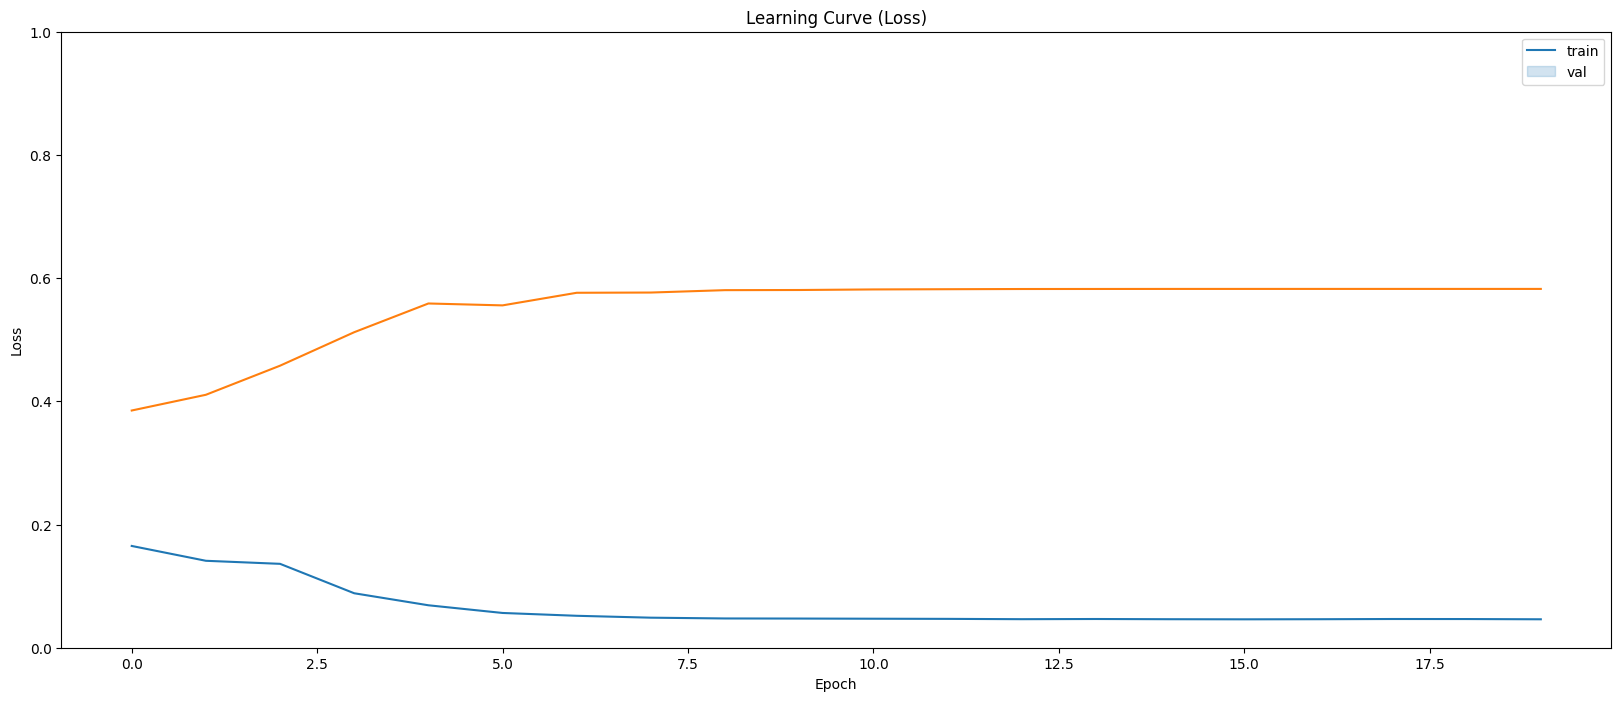

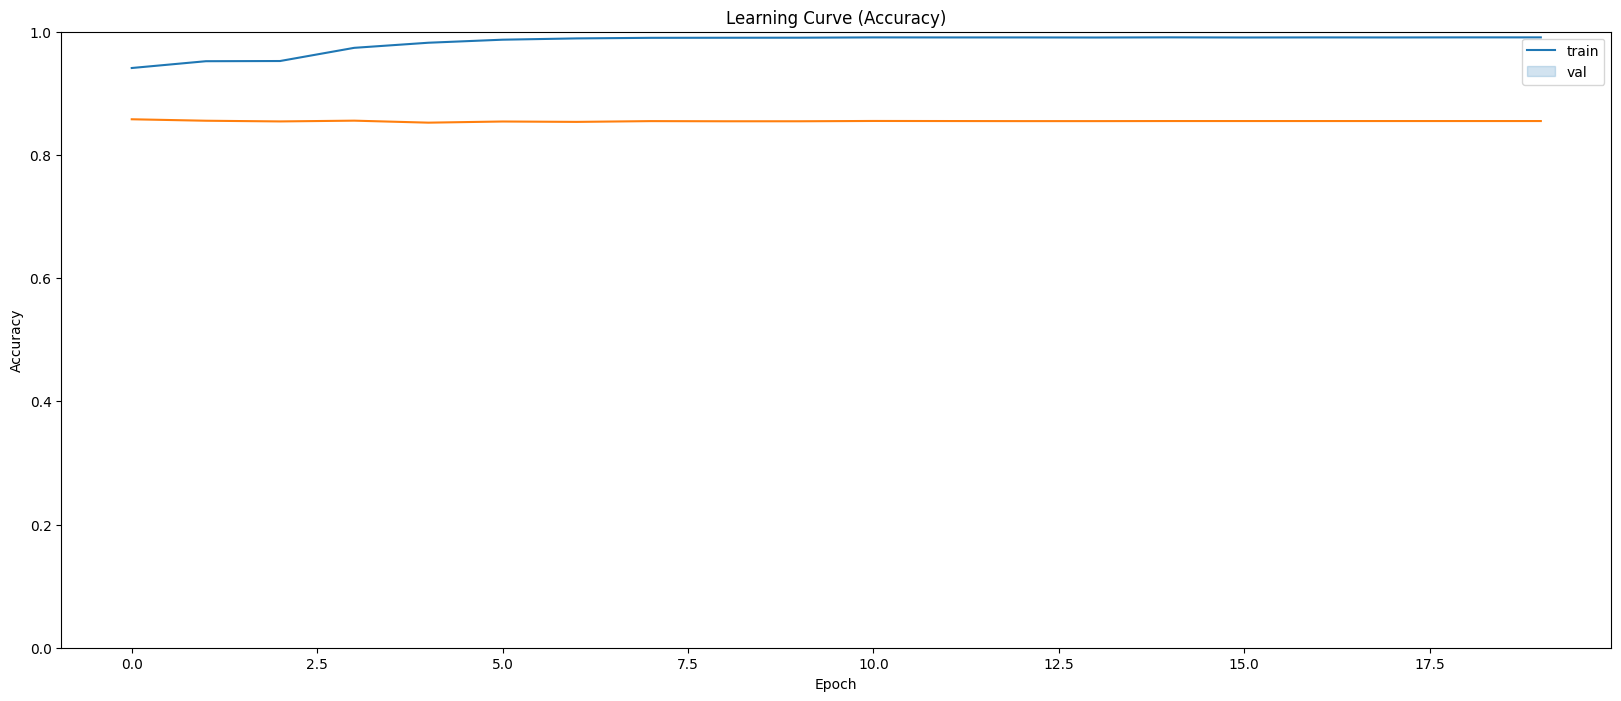

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history3.epoch, y = history3.history['loss'])
sns.lineplot(x = history3.epoch, y = history3.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history3.epoch, y = history3.history['acc'])
sns.lineplot(x = history3.epoch, y = history3.history['val_acc'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()